# Machine learning
In this notebook we implement a few models to train on the df_cleaned.csv and df_cancel.csv datasets.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the files.
df = pd.read_csv('df_cleaned.csv')
df_cancel = pd.read_csv('df_cancel.csv')

In [48]:
# Add the missing columns to the regular flights dataframe
df['CANCELLED'] = False
df['CANCELLATION_CODE'] = np.nan 
df['DIVERTED'] = False

df['CANCELLED'] = df['CANCELLED'].astype(bool)
df['DIVERTED'] = df['DIVERTED'].astype(bool)

# Combine the dataframes
combined_flights = pd.concat([df, df_cancel], ignore_index=True)


Here we format the time attributes HH:MM into minutes from midnight:

In [49]:
print(combined_flights.iloc[39]['DEP_TIME'])

14:34


In [50]:
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    hours, minutes = map(int, time_str.split(":"))
    return hours * 60 + minutes

time_columns = ['CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'CRS_ARR_TIME', 'ARR_TIME']

# Combine approaches
for col in time_columns:
    combined_flights[col] = combined_flights[col].apply(time_to_minutes)

print(combined_flights.iloc[39]['DEP_TIME'])

874.0


Now we decide what attribute we will try to predict and what attributes should be available for the prediction.

For this, let's once again review the attributes list:

<font color='green'> **Green colored attributes are available before the flight**</font>
 
<font color='lightblue'> **Blue colored attributes signify attributes that we can or want to predict**   </font> 

- <font color='green'>OP_CARRIER        </font> 
- <font color='green'>OP_CARRIER_FL_NUM </font> 
- <font color='green'>ORIGIN            </font> 
- <font color='green'>DEST              </font> 
- <font color='green'>CRS_DEP_TIME      </font> 
- <font color='green'>CRS_ARR_TIME      </font> 
- <font color='green'>CRS_ELAPSED_TIME  </font> 
- <font color='green'>DISTANCE          </font> 
- <font color='green'>MONTH             </font> 
- <font color='green'>DAY               </font> 
- <font color='green'>YEAR              </font> 
- <font color='green'>DAY_OF_WEEK       </font> 
- DEP_TIME           - <font color='green'DEP_TIME   K       </font> AY              
- TAXI_OUT               
- WHEELS_OFF             
- WHEELS_ON              
- TAXI_IN                
- ARR_TIME               
- <font color='lightblue'>ARR_DELAY</font>
- ACTUAL_ELAPSED_TIME    
- AIR_TIME               
- CARRIER_DELAY          
- WEATHER_DELAY          
- NAS_DELAY              
- SECURITY_DELAY         
- LATE_AIRCRAFT_DELAY    
- <font color='lightblue'> CANCELLED        </font>     
- <font color='lightblue'> CANCELLATION_CODE</font>    
- <font color='lightblue'> DIVERTED         </font>       

In [51]:
print(combined_flights.dtypes)

OP_CARRIER              object
OP_CARRIER_FL_NUM        int64
ORIGIN                  object
DEST                    object
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
CRS_ELAPSED_TIME         int64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE                 int64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
MONTH                    int64
DAY                      int64
YEAR                     int64
DAY_OF_WEEK              int64
CANCELLED                 bool
CANCELLATION_CODE       object
DIVERTED                  bool
dtype: object


In [52]:
%pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\jaano\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [54]:
# Preprocessing function
def preprocess_for_arrival_delay(combined_flights):
    # Select features for prediction
    features = [
        'OP_CARRIER', 
        'ORIGIN', 
        'DEST', 
        'CRS_DEP_TIME', 
        'CRS_ARR_TIME', 
        'CRS_ELAPSED_TIME', 
        'DISTANCE', 
        'MONTH', 
        'DAY', 
        'YEAR', 
        'DAY_OF_WEEK',
        'DEP_TIME'
    ]
    
    # Create a copy of the dataframe
    df = combined_flights[features + ['ARR_DELAY']].copy()
    
    # Handle missing values
    df.dropna(inplace=True)
    
    # Convert time columns to numeric minutes
    def time_to_minutes(time_value):
        if pd.isna(time_value):
            return np.nan
        
        # If it's a numeric value like 1430
        time_value = int(time_value)
        hours = time_value // 100
        minutes = time_value % 100
        return hours * 60 + minutes
    
    df['CRS_DEP_TIME_MINUTES'] = df['CRS_DEP_TIME'].apply(time_to_minutes)
    df['CRS_ARR_TIME_MINUTES'] = df['CRS_ARR_TIME'].apply(time_to_minutes)
    
    # Drop original time columns
    df.drop(columns=['CRS_DEP_TIME', 'CRS_ARR_TIME'], inplace=True)
    
    # Separate features and target
    X = df.drop('ARR_DELAY', axis=1)
    y = df['ARR_DELAY']
    
    return X, y

# Example prediction
def predict_arrival_delay(model, flight_data):
    # Preprocess the input data similar to training data
    processed_data = preprocess_for_arrival_delay(flight_data)[0]
    
    # Make prediction
    predicted_delay = model.predict(processed_data)
    
    return predicted_delay

# Optional: Feature importance
def get_feature_importance(model):
    # Get feature names directly from the preprocessor
    preprocessor = model.named_steps['preprocessor']
    
    # Get numeric feature names
    numeric_transformer = preprocessor.named_transformers_['num']
    numeric_feature_names = numeric_transformer.get_feature_names_out().tolist()
    
    # Get categorical feature names
    categorical_transformer = preprocessor.named_transformers_['cat']
    categorical_feature_names = categorical_transformer.get_feature_names_out().tolist()
    
    # Combine feature names
    feature_names = numeric_feature_names + categorical_feature_names
    
    # Get feature importances
    importances = model.named_steps['regressor'].feature_importances_
    
    # Create a DataFrame of features and their importances
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return feature_importance_df

def predict_if_flight_delayed(model, flight_data, delay_threshold=0.1):
    # Preprocess the input data similar to training data
    processed_data = preprocess_for_arrival_delay(flight_data)[0]
    
    # Make prediction
    predicted_delay = model.predict(processed_data)
    
    # Determine if the flight is delayed
    is_delayed = predicted_delay > delay_threshold
    
    return is_delayed


def are_flights_delayed_test(model, flights_count=100):
    successful = 0
    
    # Randomly select 100 rows from the DataFrame
    random_flights = combined_flights.sample(n=flights_count, random_state=42)
    
    for i, single_flight in random_flights.iterrows():
        single_flight = single_flight.to_frame().T  # Convert Series to DataFrame
        will_delay = predict_if_flight_delayed(model, single_flight)
        was_delayed = single_flight['ARR_DELAY'].item() > 0
        
        if will_delay[0] == was_delayed:
            successful += 1

    return successful / flights_count



Now let's create a function to train a model using Random Forest Regression.

In [55]:
def train_arrival_delay_model(combined_flights):
    # Preprocess data
    X, y = preprocess_for_arrival_delay(combined_flights)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define preprocessing for numeric and categorical columns
    numeric_features = [
        'CRS_DEP_TIME_MINUTES', 
        'CRS_ARR_TIME_MINUTES', 
        'CRS_ELAPSED_TIME', 
        'DISTANCE', 
        'MONTH', 
        'DAY', 
        'YEAR', 
        'DAY_OF_WEEK',
        'DEP_TIME'
    ]
    
    categorical_features = [
        'OP_CARRIER', 
        'ORIGIN', 
        'DEST'
    ]
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Create a pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Model Performance:")
    print(f"Mean Absolute Error: {mae:.2f} minutes")
    print(f"Root Mean Squared Error: {rmse:.2f} minutes")
    print(f"R-squared Score: {r2:.4f}")
    
    return model

Now one model that's using linear regression.

In [62]:
from sklearn.linear_model import LinearRegression

def train_arrival_delay_model_linear_regression(combined_flights):
    # Preprocess data
    X, y = preprocess_for_arrival_delay(combined_flights)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define preprocessing for numeric and categorical columns
    numeric_features = [
        'CRS_DEP_TIME_MINUTES', 
        'CRS_ARR_TIME_MINUTES', 
        'CRS_ELAPSED_TIME', 
        'DISTANCE', 
        'MONTH', 
        'DAY', 
        'YEAR', 
        'DAY_OF_WEEK',
        'DEP_TIME'
    ]
    
    categorical_features = [
        'OP_CARRIER', 
        'ORIGIN', 
        'DEST'
    ]
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Create a pipeline with Linear Regression
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Linear Regression Model Performance:")
    print(f"Mean Absolute Error: {mae:.2f} minutes")
    print(f"Root Mean Squared Error: {rmse:.2f} minutes")
    print(f"R-squared Score: {r2:.4f}")
    
    return model

One for Gradient Boosting (GBM) model. 

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

def train_arrival_delay_model_gbm(combined_flights):
    # Preprocess data
    X, y = preprocess_for_arrival_delay(combined_flights)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define preprocessing for numeric and categorical columns
    numeric_features = [
        'CRS_DEP_TIME_MINUTES', 
        'CRS_ARR_TIME_MINUTES', 
        'CRS_ELAPSED_TIME', 
        'DISTANCE', 
        'MONTH', 
        'DAY', 
        'YEAR', 
        'DAY_OF_WEEK',
        'DEP_TIME'
    ]
    
    categorical_features = [
        'OP_CARRIER', 
        'ORIGIN', 
        'DEST'
    ]
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Create a pipeline with GradientBoostingRegressor
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Gradient Boosting Machine (GBM) Model Performance:")
    print(f"Mean Absolute Error: {mae:.2f} minutes")
    print(f"Root Mean Squared Error: {rmse:.2f} minutes")
    print(f"R-squared Score: {r2:.4f}")
    
    return model

In [64]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\jaano\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [65]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def train_arrival_delay_model_lightgbm(combined_flights):
    
    # Preprocess data
    X, y = preprocess_for_arrival_delay(combined_flights)
    X.fillna(-1, inplace=True)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing for numeric and categorical columns
    numeric_features = [
        'CRS_DEP_TIME_MINUTES', 
        'CRS_ARR_TIME_MINUTES', 
        'CRS_ELAPSED_TIME', 
        'DISTANCE', 
        'MONTH', 
        'DAY', 
        'YEAR', 
        'DAY_OF_WEEK',
        'DEP_TIME'
    ]
    categorical_features = [
        'OP_CARRIER', 
        'ORIGIN', 
        'DEST'
    ]

    # Create a preprocessor
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # Create a pipeline with LightGBM using fixed hyperparameters
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', lgb.LGBMRegressor(
            num_leaves=100,
            n_estimators=650,
            max_depth=75,
            learning_rate=0.01,
            colsample_bytree=0.75,
            verbosity=-1,
            random_state=42
        ))
    ])

    # Train the pipeline
    model_pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model_pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("\nLightGBM Model Performance with Fixed Hyperparameters:")
    print(f"Mean Absolute Error: {mae:.2f} minutes")
    print(f"Root Mean Squared Error: {rmse:.2f} minutes")
    print(f"R-squared Score: {r2:.4f}")

    return model_pipeline


Now let's train and test the models.

In [66]:
chosen_flight = 15
single_flight = combined_flights.iloc[[chosen_flight]]
print(f"Actual delay : {single_flight['ARR_DELAY']}")

# Take a sample
combined_flights_2 = combined_flights.sample(frac=0.0015, random_state=42)

## RFR prediction.
arrival_delay_model = train_arrival_delay_model(combined_flights_2)
predicted_delay = predict_arrival_delay(arrival_delay_model, single_flight)
print("Predicted Delay (RFR):", predicted_delay)

## LINEAR REGRESSION prediction.
print("---")
arrival_delay_model_2 = train_arrival_delay_model_linear_regression(combined_flights_2)
predicted_delay = predict_arrival_delay(arrival_delay_model_2, single_flight)
print("Predicted Delay (LR):", predicted_delay)


## GBM prediction.
print("---")
arrival_delay_model_3 = train_arrival_delay_model_gbm(combined_flights_2)
predicted_delay = predict_arrival_delay(arrival_delay_model_3, single_flight)
print("Predicted Delay (GBM):", predicted_delay)


## lightGBM prediction.
arrival_delay_model_4 = train_arrival_delay_model_lightgbm(combined_flights_2)
predicted_delay = predict_arrival_delay(arrival_delay_model_4, single_flight)
print("Predicted Delay (lightGBM):", predicted_delay)


# PREDICTIONS IF FLIGHTS WERE DELAYED OR NOT.
rfr_pred = are_flights_delayed_test(arrival_delay_model)
linear_pred = are_flights_delayed_test(arrival_delay_model_2)
gbm_pred = are_flights_delayed_test(arrival_delay_model_3)
lightgbm_pred = are_flights_delayed_test(arrival_delay_model_4)

print("RFR prediction if flights are delayed:", rfr_pred)
print("Linear Regression prediction if flights are delayed:", linear_pred)
print("GBM prediction if flights are delayed:", gbm_pred)
print("LightGBM prediction if flights are delayed:", lightgbm_pred)

Actual delay : 15    7.0
Name: ARR_DELAY, dtype: float64
Model Performance:
Mean Absolute Error: 13.22 minutes
Root Mean Squared Error: 22.49 minutes
R-squared Score: 0.6989
Predicted Delay (RFR): [-9.54]
---
Linear Regression Model Performance:
Mean Absolute Error: 21.37 minutes
Root Mean Squared Error: 39.57 minutes
R-squared Score: 0.0677
Predicted Delay (LR): [27.78941789]
---
Gradient Boosting Machine (GBM) Model Performance:
Mean Absolute Error: 15.00 minutes
Root Mean Squared Error: 23.60 minutes
R-squared Score: 0.6683
Predicted Delay (GBM): [-4.36548666]

LightGBM Model Performance with Fixed Hyperparameters:
Mean Absolute Error: 13.58 minutes
Root Mean Squared Error: 22.74 minutes
R-squared Score: 0.6921
Predicted Delay (lightGBM): [-22.96335856]
RFR prediction if flights are delayed: 0.87
Linear Regression prediction if flights are delayed: 0.66
GBM prediction if flights are delayed: 0.63
LightGBM prediction if flights are delayed: 0.82


Let's visualize the models' performance on predicting if a flight will be delayed or not.

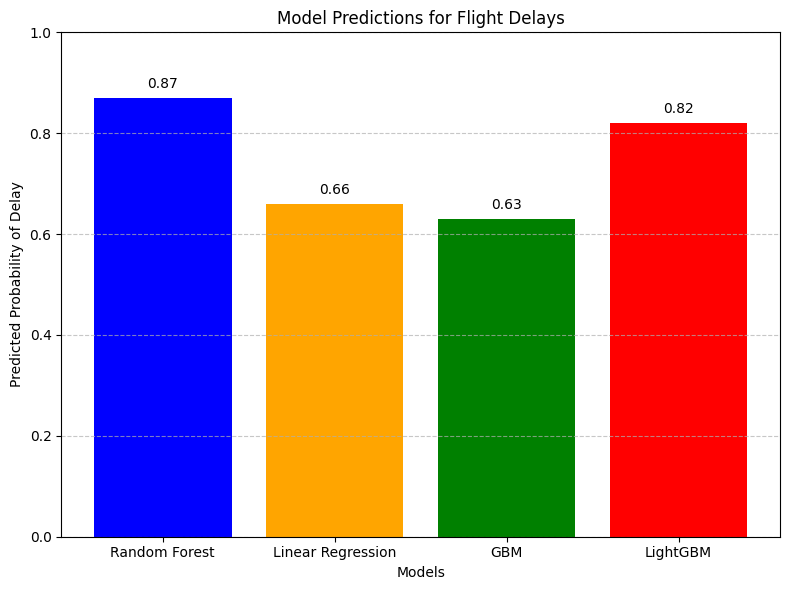

In [69]:
# Model names and corresponding predictions
model_names = ['Random Forest', 'Linear Regression', 'GBM', 'LightGBM']
predictions = [rfr_pred, linear_pred, gbm_pred, lightgbm_pred]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(model_names, predictions, color=['blue', 'orange', 'green', 'red'])
plt.title('Model Predictions for Flight Delays')
plt.ylabel('Predicted Probability of Delay')
plt.xlabel('Models')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for i, value in enumerate(predictions):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("ModelPredictionsForFlightDelays.pdf")
plt.show()

## Feature engineering: number of concurrent flights: congestion level

First let's make a new attribute to ease the calculations, lets take a look at our current date and time format.

In [74]:
print(combined_flights[['MONTH', 'DAY', 'CRS_DEP_TIME']].dtypes)
print("\nRandom Row Values:")
print(combined_flights.iloc[33][['MONTH', 'DAY', 'CRS_DEP_TIME']])

MONTH           int64
DAY             int64
CRS_DEP_TIME    int64
dtype: object

Random Row Values:
MONTH             1
DAY               1
CRS_DEP_TIME    630
Name: 33, dtype: object


Let's reformat this into a more convinient form

In [76]:
combined_flights['flight_datetime'] = pd.to_datetime({
    'year': 2013,
    'month': combined_flights['MONTH'],
    'day': combined_flights['DAY'],
    'hour': combined_flights['CRS_DEP_TIME'] // 60,
    'minute': combined_flights['CRS_DEP_TIME'] % 60
})


**What is the congestion level?**

We look at all the flights taking off from a specific airport. If these flights are designated to take off within a short timeframe, we can presume that the runway traffic or taking off in general might become difficult. 

The primary question here would be, what is the correct timeframe? We have currently opted for 2 hours, meaning if another flight was planned to take off within 2 hours we consider it might congest the flight and add 1 to the score. 

The timeframe could be far longer, 4, 5, 6, 7 hours etc.

Flight Datetime Range:
Earliest: 2013-01-01 00:40:00
Latest: 2013-12-31 23:59:00

Flight Datetime Distribution:
flight_datetime
0       892
1       380
2        81
3        62
4        43
5      7683
6     43366
7     42880
8     44217
9     37880
10    41965
11    41526
12    40324
13    42140
14    37952
15    40146
16    39455
17    45034
18    35997
19    36720
20    26568
21    18905
22     9609
23     3123
Name: count, dtype: int64


C:\Users\jaano\AppData\Local\Temp\ipykernel_27428\3450390411.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  congestion_results = df_sorted.groupby('ORIGIN').apply(count_concurrent_flights)


Congestion Level Summary:
count    636948.000000
mean          9.589260
std           8.262921
min           1.000000
25%           3.000000
50%           7.000000
75%          14.000000
max          48.000000
Name: CONGESTION_LEVEL, dtype: float64

Top 10 Airports by Maximum Congestion:
       CONGESTION_LEVEL           
                   mean max  count
ORIGIN                            
ATL           27.598007  48  39645
ORD           21.483980  45  30774
DFW           20.541378  42  28590
DEN           16.360986  37  22566
LAX           14.603688  33  22558
IAH           13.530044  32  18157
DTW           12.690660  31  16435
SFO           11.161812  29  16958
PHX           12.791332  27  17789
MSP           10.989212  25  14831


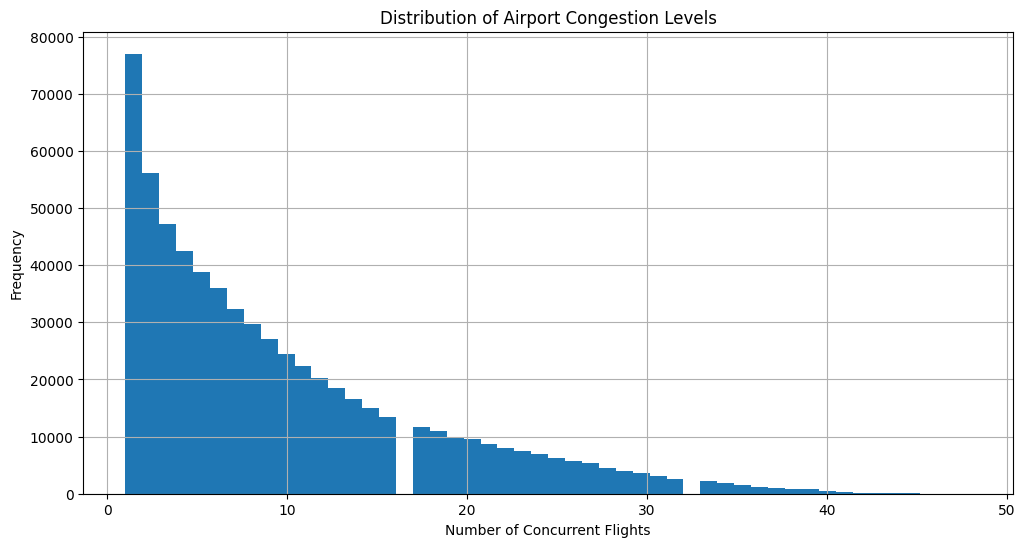

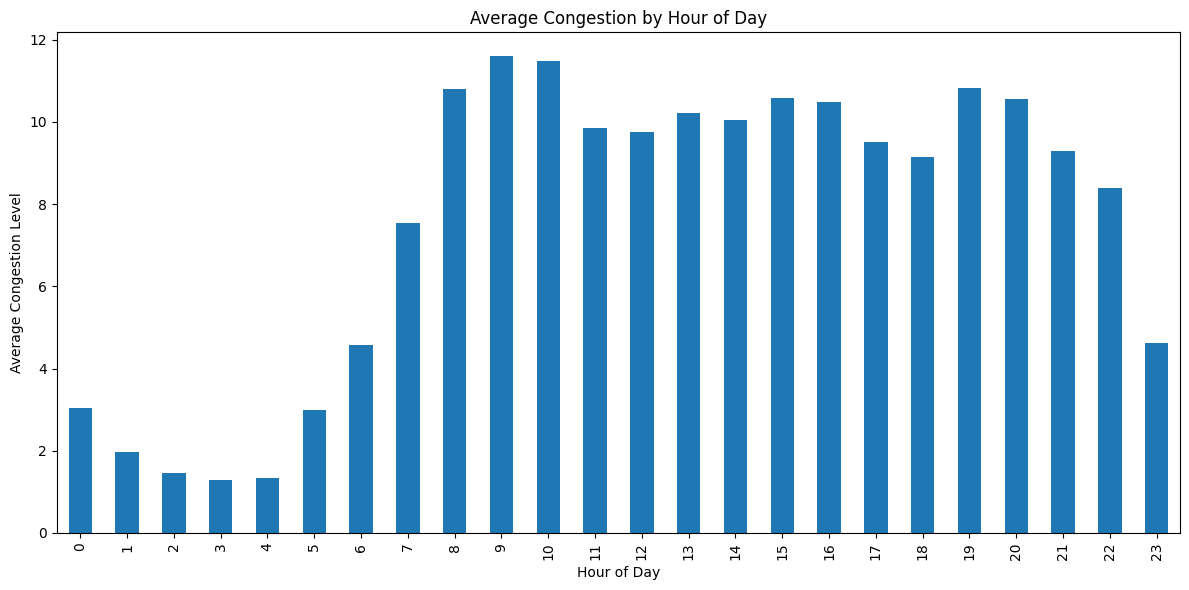

In [77]:
import pandas as pd
import numpy as np

def calculate_airport_congestion(combined_flights, time_window_minutes=120):
    # Create a copy of the dataframe
    df = combined_flights.copy()
    
    # Sort by airport and datetime
    df_sorted = df.sort_values(['ORIGIN', 'flight_datetime'])
    
    def count_concurrent_flights(group):
        # Use the existing flight_datetime
        full_datetimes = group['flight_datetime']
        
        # Initialize congestion array
        congestion = np.zeros(len(full_datetimes), dtype=int)
        
        for i, current_datetime in enumerate(full_datetimes):
            # Create time window mask
            mask = (np.abs(full_datetimes - current_datetime) <= pd.Timedelta(minutes=time_window_minutes))
            congestion[i] = np.sum(mask)
        
        return pd.Series(congestion, name='CONGESTION_LEVEL', index=group.index)
    
    # Group by origin and calculate congestion
    congestion_results = df_sorted.groupby('ORIGIN').apply(count_concurrent_flights)
    
    # Flatten the multi-index series
    congestion_results = congestion_results.reset_index(level=0, drop=True)
    
    # Add congestion level to the dataframe
    df['CONGESTION_LEVEL'] = 0  # Initialize with zeros
    df.loc[congestion_results.index, 'CONGESTION_LEVEL'] = congestion_results
    
    return df

# Comprehensive analysis function
def analyze_congestion(df, top_n=10):
    # Basic congestion summary
    print("Congestion Level Summary:")
    print(df['CONGESTION_LEVEL'].describe())
    
    # Top airports by congestion
    airport_congestion = df.groupby('ORIGIN').agg({
        'CONGESTION_LEVEL': ['mean', 'max', 'count']
    }).sort_values(('CONGESTION_LEVEL', 'max'), ascending=False)
    
    print(f"\nTop {top_n} Airports by Maximum Congestion:")
    print(airport_congestion.head(top_n))
    
    # Visualization
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12,6))
    df['CONGESTION_LEVEL'].hist(bins=50)
    plt.title('Distribution of Airport Congestion Levels')
    plt.xlabel('Number of Concurrent Flights')
    plt.ylabel('Frequency')
    plt.show()
    
    return airport_congestion

# Diagnostic function to check data quality
def diagnose_time_conversion(df):
    print("Flight Datetime Range:")
    print(f"Earliest: {df['flight_datetime'].min()}")
    print(f"Latest: {df['flight_datetime'].max()}")
    
    print("\nFlight Datetime Distribution:")
    print(df['flight_datetime'].dt.hour.value_counts().sort_index())

# Example usage with diagnostics
def main_analysis(combined_flights):
    # Sample a fraction of the data
    combined_flights_sample = combined_flights.sample(frac=0.1, random_state=42)
    
    # Diagnose time conversion
    diagnose_time_conversion(combined_flights_sample)
    
    # Calculate congestion
    result = calculate_airport_congestion(combined_flights_sample)
    
    # Analyze congestion
    congestion_analysis = analyze_congestion(result)
    
    return result, congestion_analysis

# Optional: Hourly congestion visualization
def plot_hourly_congestion(df):
    import matplotlib.pyplot as plt
    
    # Group by hour and calculate mean congestion
    hourly_congestion = df.groupby(df['flight_datetime'].dt.hour)['CONGESTION_LEVEL'].mean()
    
    plt.figure(figsize=(12,6))
    hourly_congestion.plot(kind='bar')
    plt.title('Average Congestion by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Congestion Level')
    plt.tight_layout()
    plt.show()

# Run the analysis
combined_flights_22 = combined_flights.sample(frac=1, random_state=42)
result, congestion_analysis = main_analysis(combined_flights_22)

# Optional additional visualization
plot_hourly_congestion(result)

### Historical route delays

**Using the data of all flight routes to find which flights are most likely to be delayed**

C:\Users\jaano\AppData\Local\Temp\ipykernel_27428\972743984.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flights_with_delay_metrics['MEAN_ROUTE_DELAY'].fillna(overall_mean_delay, inplace=True)
C:\Users\jaano\AppData\Local\Temp\ipykernel_27428\972743984.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

Route Delay Metrics Summary:
Total Routes Analyzed: 4732
Routes with 10+ Flights: 4570

Delay Statistics:
       MEAN_ROUTE_DELAY  MEDIAN_ROUTE_DELAY  MAX_ROUTE_DELAY  \
count       4707.000000         4707.000000      4707.000000   
mean           6.342684           -3.102826       389.214574   
std           10.166631            9.284728       248.706504   
min          -35.000000          -37.000000       -35.000000   
25%            1.624757           -6.000000       242.000000   
50%            5.726477           -4.000000       333.000000   
75%           10.000000           -1.000000       460.000000   
max          315.000000          315.000000      1983.000000   

       ROUTE_DELAY_SEVERITY  
count           4570.000000  
mean              33.049691  
std               10.938138  
min                4.000000  
25%               25.897143  
50%               31.397919  
75%               38.719509  
max              208.500000  

Top 10 Routes by Delay Severity:
     ORIGIN D

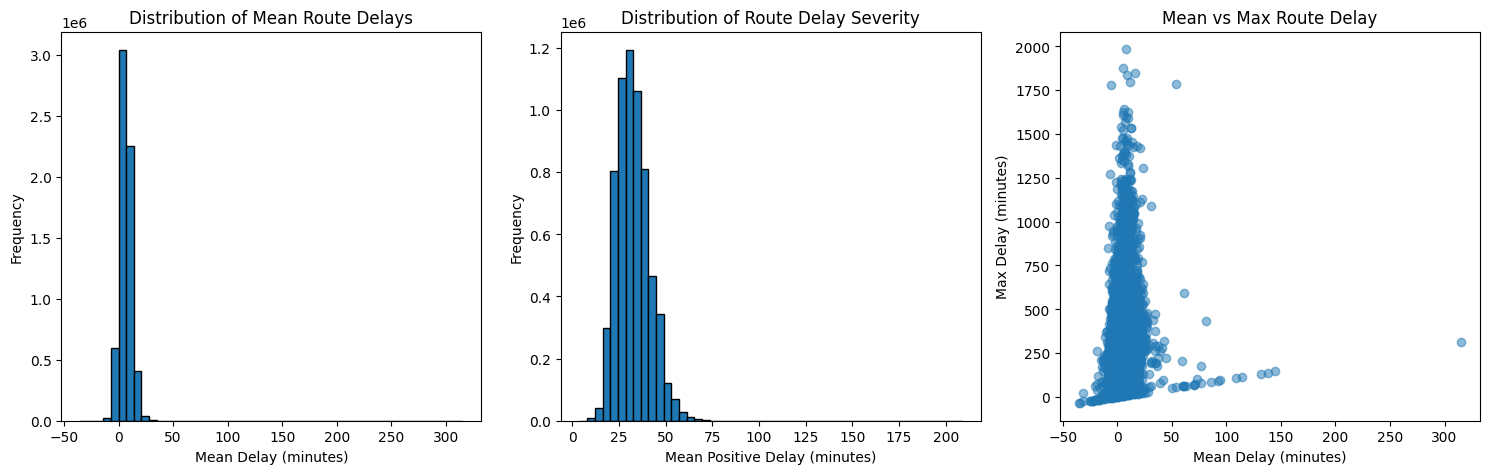

In [80]:
def add_historical_route_delay_severity(flights_df, min_flights=10):
    """
    Calculate route delay severity based on actual delay minutes
    
    Parameters:
    - flights_df: Input dataframe
    - min_flights: Minimum number of flights for a route to be considered
    """
    # Calculate route delay statistics
    route_delay_stats = flights_df.groupby(['ORIGIN', 'DEST']).agg({
        'ARR_DELAY': [
            ('mean_delay', 'mean'),           # Average delay for the route
            ('median_delay', 'median'),        # Median delay for the route
            ('max_delay', 'max'),              # Maximum delay for the route
            ('total_delay_minutes', 'sum'),    # Total delay minutes
            ('delay_severity', lambda x: np.mean(np.abs(x[x > 0]))),  # Mean of positive delays
            ('total_flights', 'count')         # Total number of flights
        ]
    }).reset_index()

    # Flatten multi-level column names
    route_delay_stats.columns = [
        'ORIGIN', 'DEST', 
        'MEAN_ROUTE_DELAY', 'MEDIAN_ROUTE_DELAY', 'MAX_ROUTE_DELAY', 
        'TOTAL_ROUTE_DELAY_MINUTES', 'MEAN_POSITIVE_DELAY', 'TOTAL_FLIGHTS'
    ]

    # Calculate delay severity metrics for routes with sufficient data
    route_delay_stats['ROUTE_DELAY_SEVERITY'] = np.where(
        route_delay_stats['TOTAL_FLIGHTS'] >= min_flights,
        route_delay_stats['MEAN_POSITIVE_DELAY'],
        np.nan
    )

    # Merge the route delay metrics back to the original dataframe
    flights_with_delay_metrics = flights_df.merge(
        route_delay_stats[[
            'ORIGIN', 'DEST', 
            'MEAN_ROUTE_DELAY', 
            'MEDIAN_ROUTE_DELAY', 
            'MAX_ROUTE_DELAY', 
            'ROUTE_DELAY_SEVERITY'
        ]],
        on=['ORIGIN', 'DEST'],
        how='left'
    )

    # Fill NaN with overall mean metrics
    overall_mean_delay = route_delay_stats['MEAN_ROUTE_DELAY'].mean()
    overall_delay_severity = route_delay_stats['ROUTE_DELAY_SEVERITY'].mean()
    
    flights_with_delay_metrics['MEAN_ROUTE_DELAY'].fillna(overall_mean_delay, inplace=True)
    flights_with_delay_metrics['ROUTE_DELAY_SEVERITY'].fillna(overall_delay_severity, inplace=True)

    # Print comprehensive statistics
    print("Route Delay Metrics Summary:")
    print(f"Total Routes Analyzed: {len(route_delay_stats)}")
    print(f"Routes with {min_flights}+ Flights: {len(route_delay_stats[route_delay_stats['TOTAL_FLIGHTS'] >= min_flights])}")
    
    print("\nDelay Statistics:")
    print(route_delay_stats[['MEAN_ROUTE_DELAY', 'MEDIAN_ROUTE_DELAY', 'MAX_ROUTE_DELAY', 'ROUTE_DELAY_SEVERITY']].describe())

    # Top 10 routes by delay severity
    print("\nTop 10 Routes by Delay Severity:")
    top_routes = route_delay_stats[route_delay_stats['TOTAL_FLIGHTS'] >= min_flights].sort_values(
        'ROUTE_DELAY_SEVERITY', 
        ascending=False
    ).head(10)
    print(top_routes)

    # Visualization
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Mean Route Delay Distribution
    plt.subplot(1, 3, 1)
    plt.hist(
        flights_with_delay_metrics['MEAN_ROUTE_DELAY'].dropna(),
        bins=50,
        edgecolor='black'
    )
    plt.title('Distribution of Mean Route Delays')
    plt.xlabel('Mean Delay (minutes)')
    plt.ylabel('Frequency')

    # Subplot 2: Route Delay Severity Distribution
    plt.subplot(1, 3, 2)
    plt.hist(
        flights_with_delay_metrics['ROUTE_DELAY_SEVERITY'].dropna(),
        bins=50,
        edgecolor='black'
    )
    plt.title('Distribution of Route Delay Severity')
    plt.xlabel('Mean Positive Delay (minutes)')
    plt.ylabel('Frequency')

    # Subplot 3: Scatter of Mean Delay vs Max Delay
    plt.subplot(1, 3, 3)
    plt.scatter(
        route_delay_stats['MEAN_ROUTE_DELAY'], 
        route_delay_stats['MAX_ROUTE_DELAY'],
        alpha=0.5
    )
    plt.title('Mean vs Max Route Delay')
    plt.xlabel('Mean Delay (minutes)')
    plt.ylabel('Max Delay (minutes)')

    plt.tight_layout()
    plt.show()

    return flights_with_delay_metrics

# Apply the function
combined_flights_with_delay_metrics = add_historical_route_delay_severity(
    combined_flights, 
    min_flights=10  # Routes with at least 10 flights
)

Now let's create a plot that shows how well do the models predict how long a flight has been delayed for.

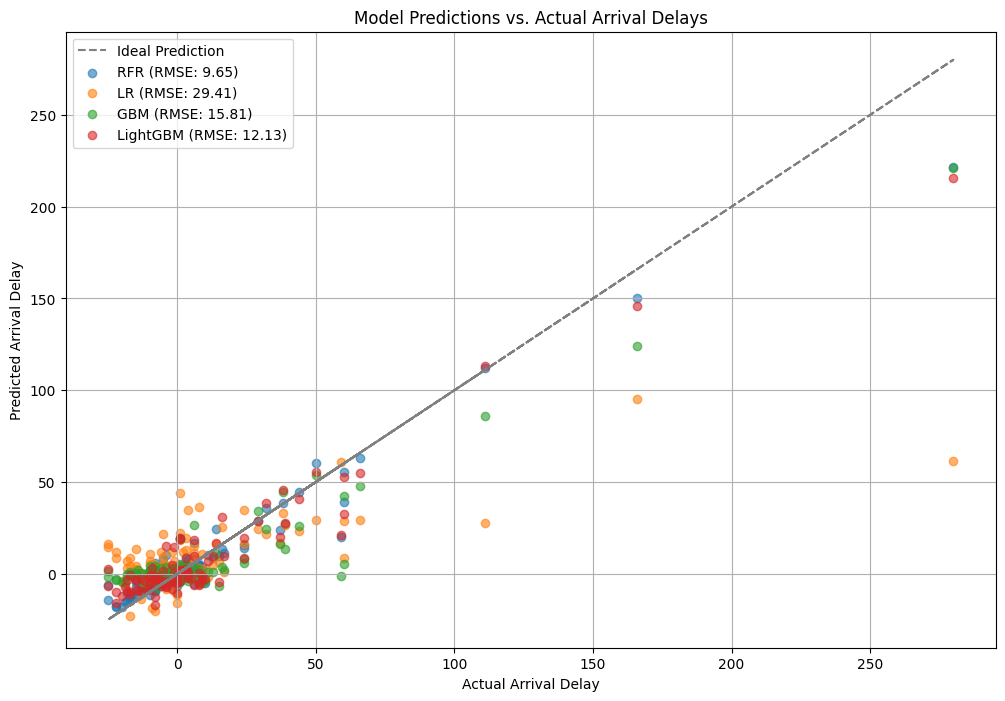

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

# Randomly sample 100 flights for testing
test_flights = combined_flights.sample(n=100, random_state=42)

# Assuming actual delays are in a column named 'arrival_delay'
actual_delays = test_flights['ARR_DELAY']

# Generate predictions for each model on the sampled test set
predicted_delays_rfr = predict_arrival_delay(arrival_delay_model, test_flights)
predicted_delays_lr = predict_arrival_delay(arrival_delay_model_2, test_flights)
predicted_delays_gbm = predict_arrival_delay(arrival_delay_model_3, test_flights)
predicted_delays_lgbm = predict_arrival_delay(arrival_delay_model_4, test_flights)

# Calculate RMSE for each model
rmse_rfr = root_mean_squared_error(actual_delays, predicted_delays_rfr)
rmse_lr = root_mean_squared_error(actual_delays, predicted_delays_lr)
rmse_gbm = root_mean_squared_error(actual_delays, predicted_delays_gbm)
rmse_lgbm = root_mean_squared_error(actual_delays, predicted_delays_lgbm)

# Create a scatter plot to compare predictions with actual delays
plt.figure(figsize=(12, 8))
plt.plot(actual_delays, actual_delays, label='Ideal Prediction', color='gray', linestyle='--')

plt.scatter(actual_delays, predicted_delays_rfr, label=f'RFR (RMSE: {rmse_rfr:.2f})', alpha=0.6)
plt.scatter(actual_delays, predicted_delays_lr, label=f'LR (RMSE: {rmse_lr:.2f})', alpha=0.6)
plt.scatter(actual_delays, predicted_delays_gbm, label=f'GBM (RMSE: {rmse_gbm:.2f})', alpha=0.6)
plt.scatter(actual_delays, predicted_delays_lgbm, label=f'LightGBM (RMSE: {rmse_lgbm:.2f})', alpha=0.6)

# Customize the plot
plt.title('Model Predictions vs. Actual Arrival Delays')
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.legend()
plt.grid()
plt.show()